<a href="https://colab.research.google.com/github/jahnavimidde/VsemML/blob/main/Researchgap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ==============================
# Rainfall Prediction - Preprocessing
# ==============================

import pandas as pd

# Step 1: Load dataset
data = pd.read_csv("/content/weatherAUS.csv")  # Replace with your file path

# Step 2: Handle missing values
# 2a: Fill numeric columns with median
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# 2b: Fill categorical columns with mode
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

# Step 3: Encode categorical features
# Convert Yes/No to 0/1
data['RainToday'] = data['RainToday'].map({'Yes':1, 'No':0})
data['RainTomorrow'] = data['RainTomorrow'].map({'Yes':1, 'No':0})

# One-hot encode categorical columns like wind direction or location
categorical_features = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location']
for col in categorical_features:
    if col in data.columns:
        data = pd.get_dummies(data, columns=[col], drop_first=True)

# Step 4: Check the preprocessed dataset
print("Shape of dataset:", data.shape)
print("Columns:", data.columns)
print("First 5 rows:\n", data.head())


Shape of dataset: (145460, 112)
Columns: Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       ...
       'Location_Townsville', 'Location_Tuggeranong', 'Location_Uluru',
       'Location_WaggaWagga', 'Location_Walpole', 'Location_Watsonia',
       'Location_Williamtown', 'Location_Witchcliffe', 'Location_Wollongong',
       'Location_Woomera'],
      dtype='object', length=112)
First 5 rows:
          Date  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01     13.4     22.9       0.6          4.8       8.4   
1  2008-12-02      7.4     25.1       0.0          4.8       8.4   
2  2008-12-03     12.9     25.7       0.0          4.8       8.4   
3  2008-12-04      9.2     28.0       0.0          4.8       8.4   
4  2008-12-05     17.5     32.3       1.0          4.8       8.4   

   WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  ...  \
0           44.0          20

In [3]:
# Drop columns that are not numeric or not useful for prediction
columns_to_drop = ['Date']  # You can add more if needed
for col in columns_to_drop:
    if col in data.columns:
        data = data.drop(col, axis=1)


In [4]:
# Check for any remaining non-numeric columns
non_numeric_cols = data.select_dtypes(include=['object']).columns
print("Remaining non-numeric columns:", non_numeric_cols)


Remaining non-numeric columns: Index([], dtype='object')


In [5]:
# ==============================
# Rainfall Prediction - Train/Test Split & Baseline Model
# ==============================

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Step 1: Split dataset into features (X) and target (y)
X = data.drop('RainTomorrow', axis=1)  # Features
y = data['RainTomorrow']                # Target variable

# Step 2: Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create a baseline Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Step 4: Train the model on training data
rf.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = rf.predict(X_test)

# Step 6: Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Baseline Random Forest Accuracy:", accuracy)


Baseline Random Forest Accuracy: 0.8516774370961089


In [ ]:
# ==============================
# Rainfall Prediction - Faster Hyperparameter Tuning
# ==============================

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Define smaller hyperparameter ranges
param_dist = {
    'n_estimators': [100, 200, 300],       # Number of trees
    'max_depth': [5, 10, 20, None],        # Maximum depth
    'min_samples_split': [2, 5, 10],       # Min samples to split a node
    'min_samples_leaf': [1, 2, 4]          # Min samples at a leaf
}

# Step 2: Use a subset of training data to speed up tuning (optional)
X_small = X_train.sample(frac=0.3, random_state=42)
y_small = y_train.loc[X_small.index]

# Step 3: Create RandomizedSearchCV object
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,          # Only 10 random combinations (faster than full grid)
    cv=3,
    scoring='accuracy',
    n_jobs=-1,          # Use all CPU cores
    random_state=42
)

# Step 4: Fit RandomizedSearchCV
random_search.fit(X_small, y_small)

# Step 5: Get best parameters and cross-validation accuracy
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)

# Step 6: Evaluate tuned model on the full test set
y_pred_tuned = random_search.predict(X_test)
print("Test Accuracy (Tuned Model):", accuracy_score(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))


Accuracy (Balanced RF): 0.8509212154544205
Confusion Matrix:
 [[21728   944]
 [ 3393  3027]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91     22672
           1       0.76      0.47      0.58      6420

    accuracy                           0.85     29092
   macro avg       0.81      0.71      0.75     29092
weighted avg       0.84      0.85      0.84     29092



✅ Tuned RandomForest Recreated
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}


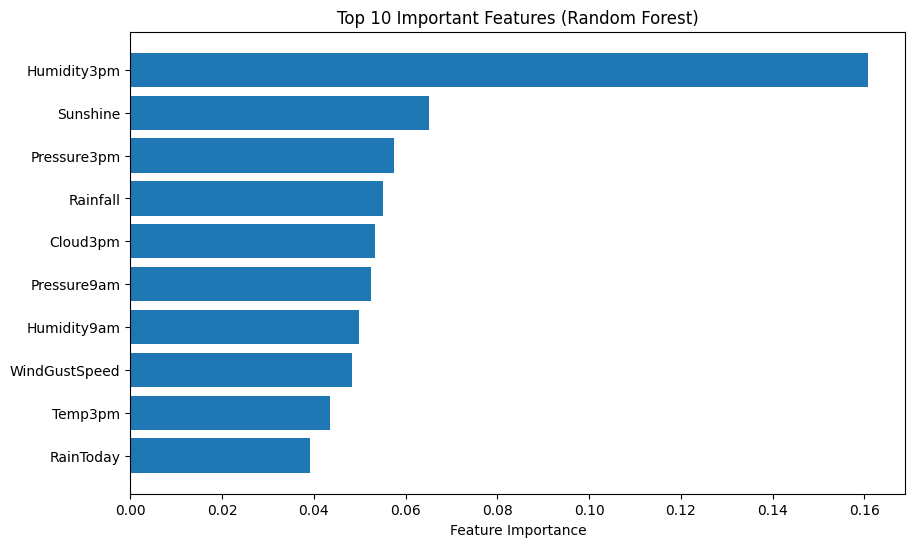

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:11:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🌟 Accuracy (XGBoost): 0.8130757596590128
Confusion Matrix (XGBoost):
 [[18594  4078]
 [ 1360  5060]]
Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.93      0.82      0.87     22672
           1       0.55      0.79      0.65      6420

    accuracy                           0.81     29092
   macro avg       0.74      0.80      0.76     29092
weighted avg       0.85      0.81      0.82     29092

[LightGBM] [Info] Number of positive: 25457, number of negative: 90911
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2730
[LightGBM] [Info] Number of data points in the train set: 116368, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



🌟 Accuracy (Stacked Ensemble): 0.8553554241715936
Confusion Matrix (Stacked):
 [[21063  1609]
 [ 2599  3821]]
Classification Report (Stacked):
               precision    recall  f1-score   support

           0       0.89      0.93      0.91     22672
           1       0.70      0.60      0.64      6420

    accuracy                           0.86     29092
   macro avg       0.80      0.76      0.78     29092
weighted avg       0.85      0.86      0.85     29092



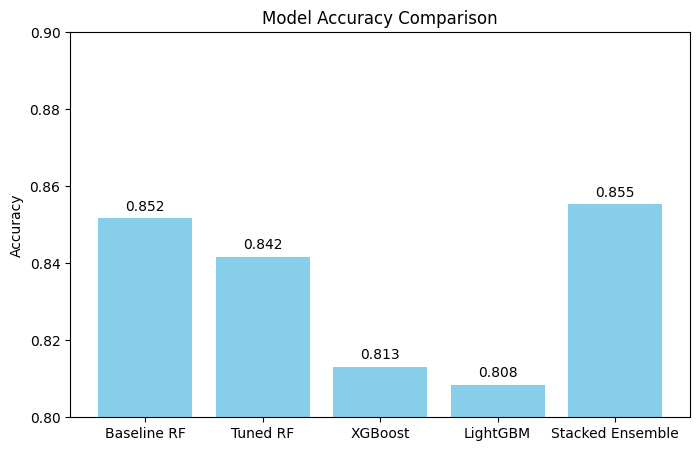

In [11]:
# =============================
# ✅ Step 0: Restore Tuned Random Forest (if runtime restarted)
# =============================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define smaller parameter space for faster tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,  # 5 random combos for faster run
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Fit on small subset for speed
X_small = X_train.sample(frac=0.3, random_state=42)
y_small = y_train.loc[X_small.index]

random_search.fit(X_small, y_small)
best_rf = random_search.best_estimator_

print("✅ Tuned RandomForest Recreated")
print("Best Hyperparameters:", random_search.best_params_)


# =============================
# 💡 Step 1: Feature Importance (from tuned Random Forest)
# =============================
import matplotlib.pyplot as plt
import numpy as np

feature_importances = best_rf.feature_importances_
features = X.columns
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10,6))
plt.barh(range(10), feature_importances[sorted_idx][:10])
plt.yticks(range(10), features[sorted_idx][:10])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()


# =============================
# 💡 Step 2: Try XGBoost Classifier
# =============================
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

xgb = XGBClassifier(
    learning_rate=0.05,
    n_estimators=300,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("\n🌟 Accuracy (XGBoost):", accuracy_score(y_test, y_pred_xgb))
print("Confusion Matrix (XGBoost):\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb))


# =============================
# 💡 Step 3: Try LightGBM Classifier
# =============================
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    learning_rate=0.05,
    n_estimators=300,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42
)

lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

print("\n🌟 Accuracy (LightGBM):", accuracy_score(y_test, y_pred_lgbm))
print("Confusion Matrix (LightGBM):\n", confusion_matrix(y_test, y_pred_lgbm))
print("Classification Report (LightGBM):\n", classification_report(y_test, y_pred_lgbm))


# =============================
# 💡 Step 4: Ensemble - Stacking Classifier
# =============================
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stack_model = StackingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', xgb),
        ('lgbm', lgbm)
    ],
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

stack_model.fit(X_train, y_train)
y_pred_stack = stack_model.predict(X_test)

print("\n🌟 Accuracy (Stacked Ensemble):", accuracy_score(y_test, y_pred_stack))
print("Confusion Matrix (Stacked):\n", confusion_matrix(y_test, y_pred_stack))
print("Classification Report (Stacked):\n", classification_report(y_test, y_pred_stack))


# =============================
# 💡 Step 5: Final Model Comparison Chart
# =============================
models = ['Baseline RF', 'Tuned RF', 'XGBoost', 'LightGBM', 'Stacked Ensemble']
accuracies = [
    0.8517,  # Baseline accuracy (from your earlier run)
    accuracy_score(y_test, best_rf.predict(X_test)),
    accuracy_score(y_test, y_pred_xgb),
    accuracy_score(y_test, y_pred_lgbm),
    accuracy_score(y_test, y_pred_stack)
]

plt.figure(figsize=(8,5))
plt.bar(models, accuracies, color='skyblue')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.8, 0.9)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.002, f"{acc:.3f}", ha='center', fontsize=10)
plt.show()
